In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def generate_data(n_samples):
    epsilon = np.random.normal(size=(n_samples))
    x_data = np.random.uniform(-10.5, 10.5, n_samples)
    y_data = 7*np.sin(0.75*x_data) + 0.5*x_data + epsilon
    return x_data, y_data

In [3]:
def gumbel_sample(x, axis=1):
    z = np.random.gumbel(loc=0, scale=1, size=x.shape)
    return (np.log(x) + z).argmax(axis=axis)

In [4]:
n_samples = 2000
x_data, y_data = generate_data(n_samples)
x_data, y_data = y_data, x_data

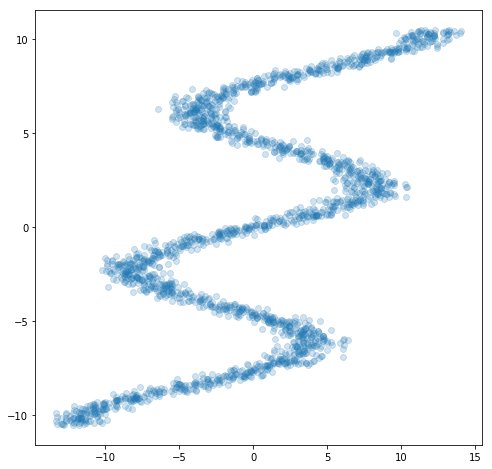

In [5]:
plt.figure(figsize=(8, 8))
plt.scatter(x_data, y_data, alpha=0.2)
plt.show()

In [6]:
X = tf.placeholder(tf.float32, [None, 1])
Y = tf.placeholder(tf.float32, [None, 1])

In [7]:
n_hidden = 25
n_gaussians = 5

In [8]:
L = tf.layers.dense(X, n_hidden, activation=tf.tanh)
pi = tf.nn.softmax(tf.layers.dense(L, n_gaussians))
sigma = tf.exp(tf.layers.dense(L, n_gaussians))
mu = tf.layers.dense(L, n_gaussians)

In [9]:
squared_dist = -tf.square((Y-mu) / sigma)/2
loss = tf.reduce_mean(-tf.reduce_logsumexp(tf.log(pi)+squared_dist-0.5*tf.log(np.pi*2*tf.square(sigma)), axis=1))
train_op = tf.train.AdamOptimizer().minimize(loss)

0 9.73573


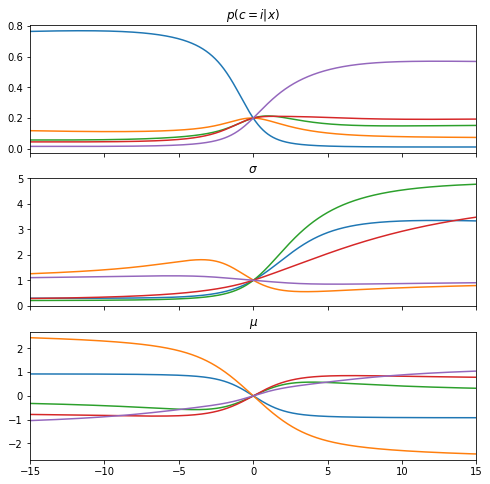

1000 2.9290195


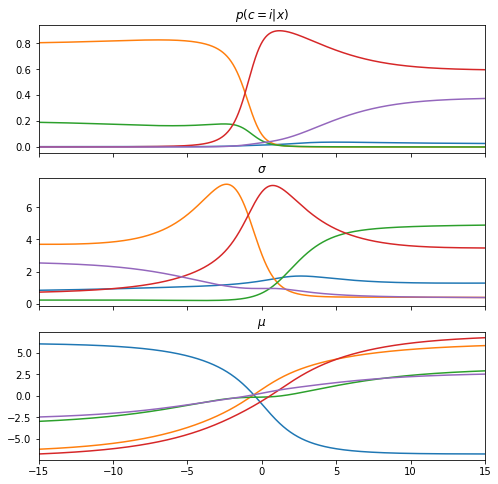

2000 2.3273036


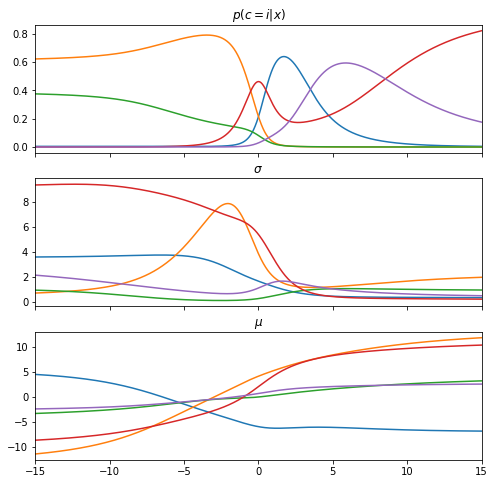

3000 1.9811374


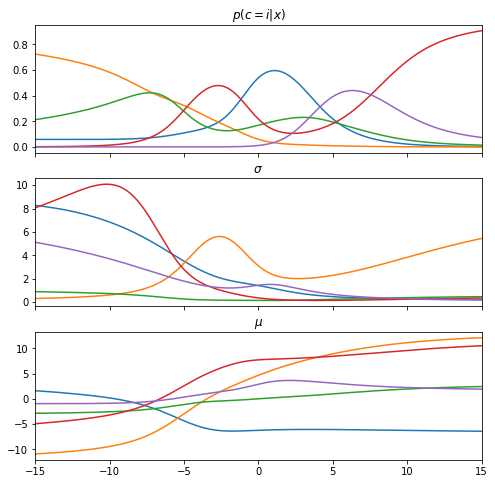

4000 1.6251782


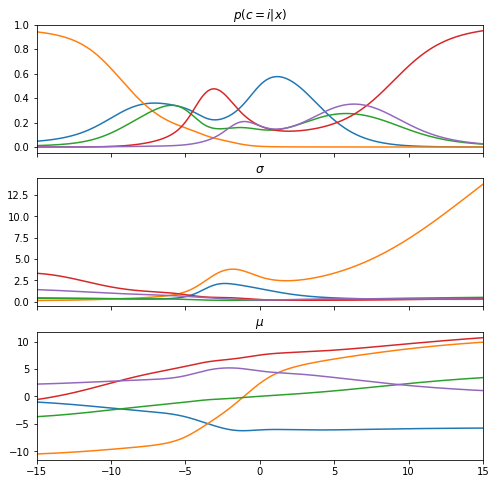

5000 1.4767529


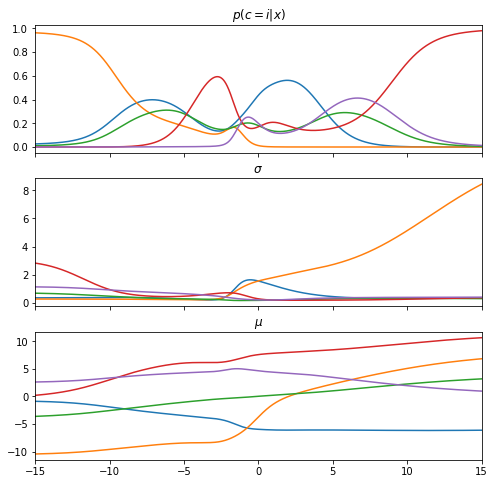

6000 1.3619345


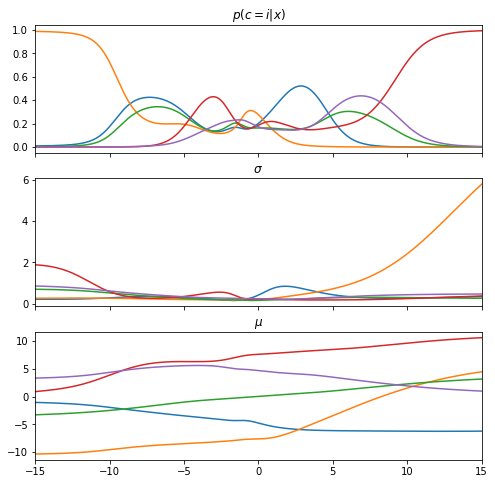

7000 1.3123468


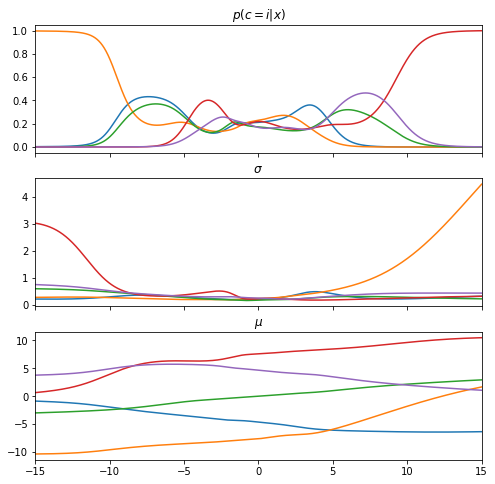

8000 1.3046354


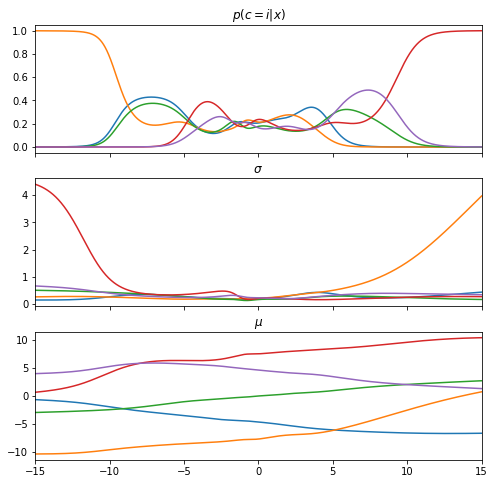

9000 1.298192


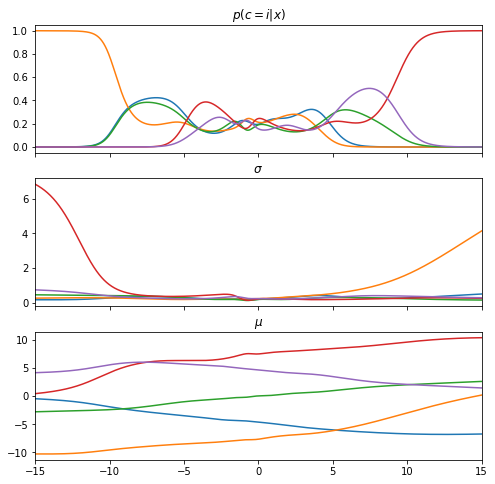

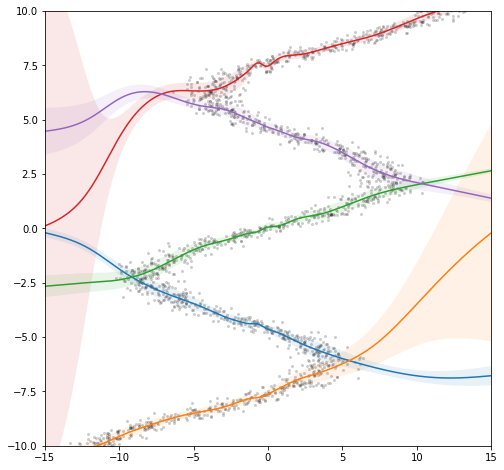

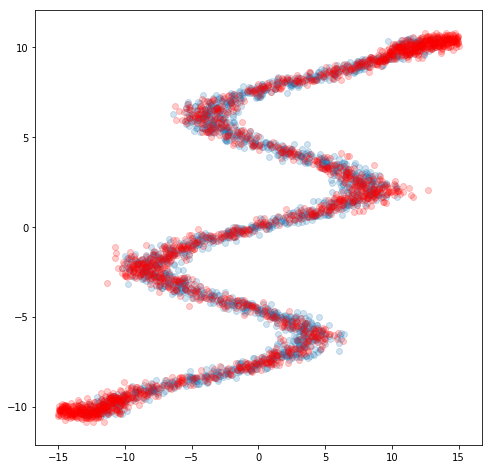

In [10]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(10000):
        _, cost = sess.run([train_op, loss], feed_dict={X: x_data.reshape(n_samples,1), Y: y_data.reshape(n_samples,1)})
        if epoch % 1000 == 0:
            print(epoch, cost)
            x_test_data = np.linspace(-15, 15, n_samples)
            pi_, mu_, sigma_ = sess.run([pi, mu, sigma], feed_dict={X:x_test_data.reshape(n_samples,1)})
            fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(8,8))
            ax1.plot(x_test_data, pi_)
            ax1.set_title('$p(c = i | x)$')
            ax2.plot(x_test_data, sigma_)
            ax2.set_title('$\sigma$')
            ax3.plot(x_test_data, mu_)
            ax3.set_title('$\mu$')
            plt.xlim([-15,15])
            plt.show()
            
    x_test_data = np.linspace(-15, 15, n_samples)
    pi_, mu_, sigma_ = sess.run([pi, mu, sigma], feed_dict={X:x_test_data.reshape(n_samples,1)})
    
    plt.figure(figsize=(8, 8), facecolor='white')
    for mu_k, sigma_k in zip(mu_.T, sigma_.T):
        plt.plot(x_test_data, mu_k)
        plt.fill_between(x_test_data, mu_k-sigma_k, mu_k+sigma_k, alpha=0.1)
    plt.scatter(x_data, y_data, marker='.', lw=0, alpha=0.2, c='black')
    plt.xlim([-15,15])
    plt.ylim([-10,10])
    plt.show()
    
    k = gumbel_sample(pi_)
    
    indices = (np.arange(n_samples), k)
    rn = np.random.randn(n_samples)
    sampled = rn * sigma_[indices] + mu_[indices]

    
    plt.figure(figsize=(8, 8))
    plt.scatter(x_data, y_data, alpha=0.2)
    plt.scatter(x_test_data, sampled, alpha=0.2, color='red')
    plt.show()